#### Single step Pyraformer working

In [1]:
%matplotlib inline

import multiprocessing
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from itertools import islice
import random
from pathlib import Path
import pandas as pd
import os
# import matplotlib.pyplot as plt
from glob import glob
from hashlib import sha1


In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from pytorch_lightning.loggers import CSVLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, DeviceStatsMonitor, EarlyStopping

from estimator import PyraformerEstimator

2023-12-06 09:55:04.864116: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 09:55:04.909689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset = get_dataset("electricity")

In [4]:
seed = 0
experiment_name = "pyraformer_ckp"
fulldir = experiment_name + "/" + str(seed)
os.makedirs(fulldir, exist_ok=True)


# Code to retrieve the version with the highest #epoch stored and restore it incl directory and its checkpoint
lightning_version_to_use, ckpt_path = None, None
max_epoch = -1
if "pyraformer_ckp" in os.listdir(fulldir):
    ckpts = glob(fulldir+ sha1(fulldir.encode("utf-8")).hexdigest()[:8] + "/checkpoints/*.ckpt")
    if len(ckpts): ckpt_path = ckpts[0]
elif "lightning_logs" in os.listdir(fulldir):
    for lightning_version in os.listdir(fulldir+"/lightning_logs/"):
        ckpts = glob(fulldir+"/lightning_logs/" + lightning_version + "/checkpoints/*.ckpt")
        if len(ckpts):
            epoch = int(ckpts[0][ckpts[0].find("=")+1:ckpts[0].find("-step")])
            if epoch > max_epoch:
                lightning_version_to_use = lightning_version
                max_epoch = epoch
                ckpt_path = ckpts[0]
    if lightning_version_to_use: print("Using lightning_version", lightning_version_to_use, "with epoch", max_epoch, "restoring from checkpoint at path", ckpt_path)


experiment_logger = CSVLogger(save_dir=fulldir)
logger = [experiment_logger]
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=50, verbose=True, mode="min")
callbacks=[early_stop_callback]

Using lightning_version version_0 with epoch 0 restoring from checkpoint at path pyraformer_ckp/0/lightning_logs/version_0/checkpoints/epoch=0-step=100.ckpt


In [16]:
estimator = PyraformerEstimator(
    # freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    # num_feat_static_cat=1,
    # cardinality=[321],
    single_step= True,
    d_model = 512,
    aug_prob = 1.0,
    aug_rate = 0.1,
    # training params
    batch_size=128,
    num_batches_per_epoch=100,

    trainer_kwargs=dict(max_epochs=50, accelerator="gpu", precision="32", logger=logger, callbacks=callbacks),
    ckpt_path = ckpt_path
)


In [ ]:
predictor = estimator.train(
    training_data=dataset.train,
    validation_data=dataset.test,
    shuffle_buffer_length=1024,
    ckpt_path = ckpt_path)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at pyraformer_ckp/0/lightning_logs/version_0/checkpoints/epoch=0-step=100.ckpt
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:338: UserWarning: The dirpath has changed from 'pyraformer_ckp/0/lightning_logs/version_0/checkpoints' to 'pyraformer_ckp/0/lightning_logs/version_13/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | PyraformerSSModel | 6.6 M 
--------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M 

Sanity Checking: 0it [00:00, ?it/s]

Training: 100it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1, global step 200: 'val_loss' reached 6.90625 (best 6.90625), saving model to 'pyraformer_ckp/0/lightning_logs/version_13/checkpoints/epoch=1-step=200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 6.639
Epoch 2, global step 300: 'val_loss' reached 6.63892 (best 6.63892), saving model to 'pyraformer_ckp/0/lightning_logs/version_13/checkpoints/epoch=2-step=300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 600: 'val_loss' was not in top 1


In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor
)


In [8]:
forecasts = list(forecast_it)

In [9]:
tss = list(ts_it)

In [10]:
num_workers = min(multiprocessing.cpu_count(), 10)

evaluator = Evaluator(num_workers=num_workers)

In [11]:
len(tss)

2247

In [12]:
len(forecasts)

2247

In [13]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 7754.45it/s]
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [14]:
agg_metrics

{'MSE': 181824652.38187027,
 'abs_error': 114777220.12780762,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 13.329905680111343,
 'MAPE': 2.3752024849374536,
 'sMAPE': 0.8586174499703839,
 'MSIS': 749.7428544664834,
 'QuantileLoss[0.1]': 25036132.346346572,
 'Coverage[0.1]': 0.10584483014389556,
 'QuantileLoss[0.2]': 48882362.92146912,
 'Coverage[0.2]': 0.20870419819017952,
 'QuantileLoss[0.3]': 71992362.44507217,
 'Coverage[0.3]': 0.30796617712505564,
 'QuantileLoss[0.4]': 94028393.17823488,
 'Coverage[0.4]': 0.39890224002373537,
 'QuantileLoss[0.5]': 114777220.40226746,
 'Coverage[0.5]': 0.4917668001780151,
 'QuantileLoss[0.6]': 133856374.39882812,
 'Coverage[0.6]': 0.5797544874647679,
 'QuantileLoss[0.7]': 150643550.18896788,
 'Coverage[0.7]': 0.6842827473668596,
 'QuantileLoss[0.8]': 163403282.1579956,
 'Coverage[0.8]': 0.7828029965880433,
 'QuantileLoss[0.9]': 164277213.55423585,
 'Coverage[0.9]': 0.8711430054

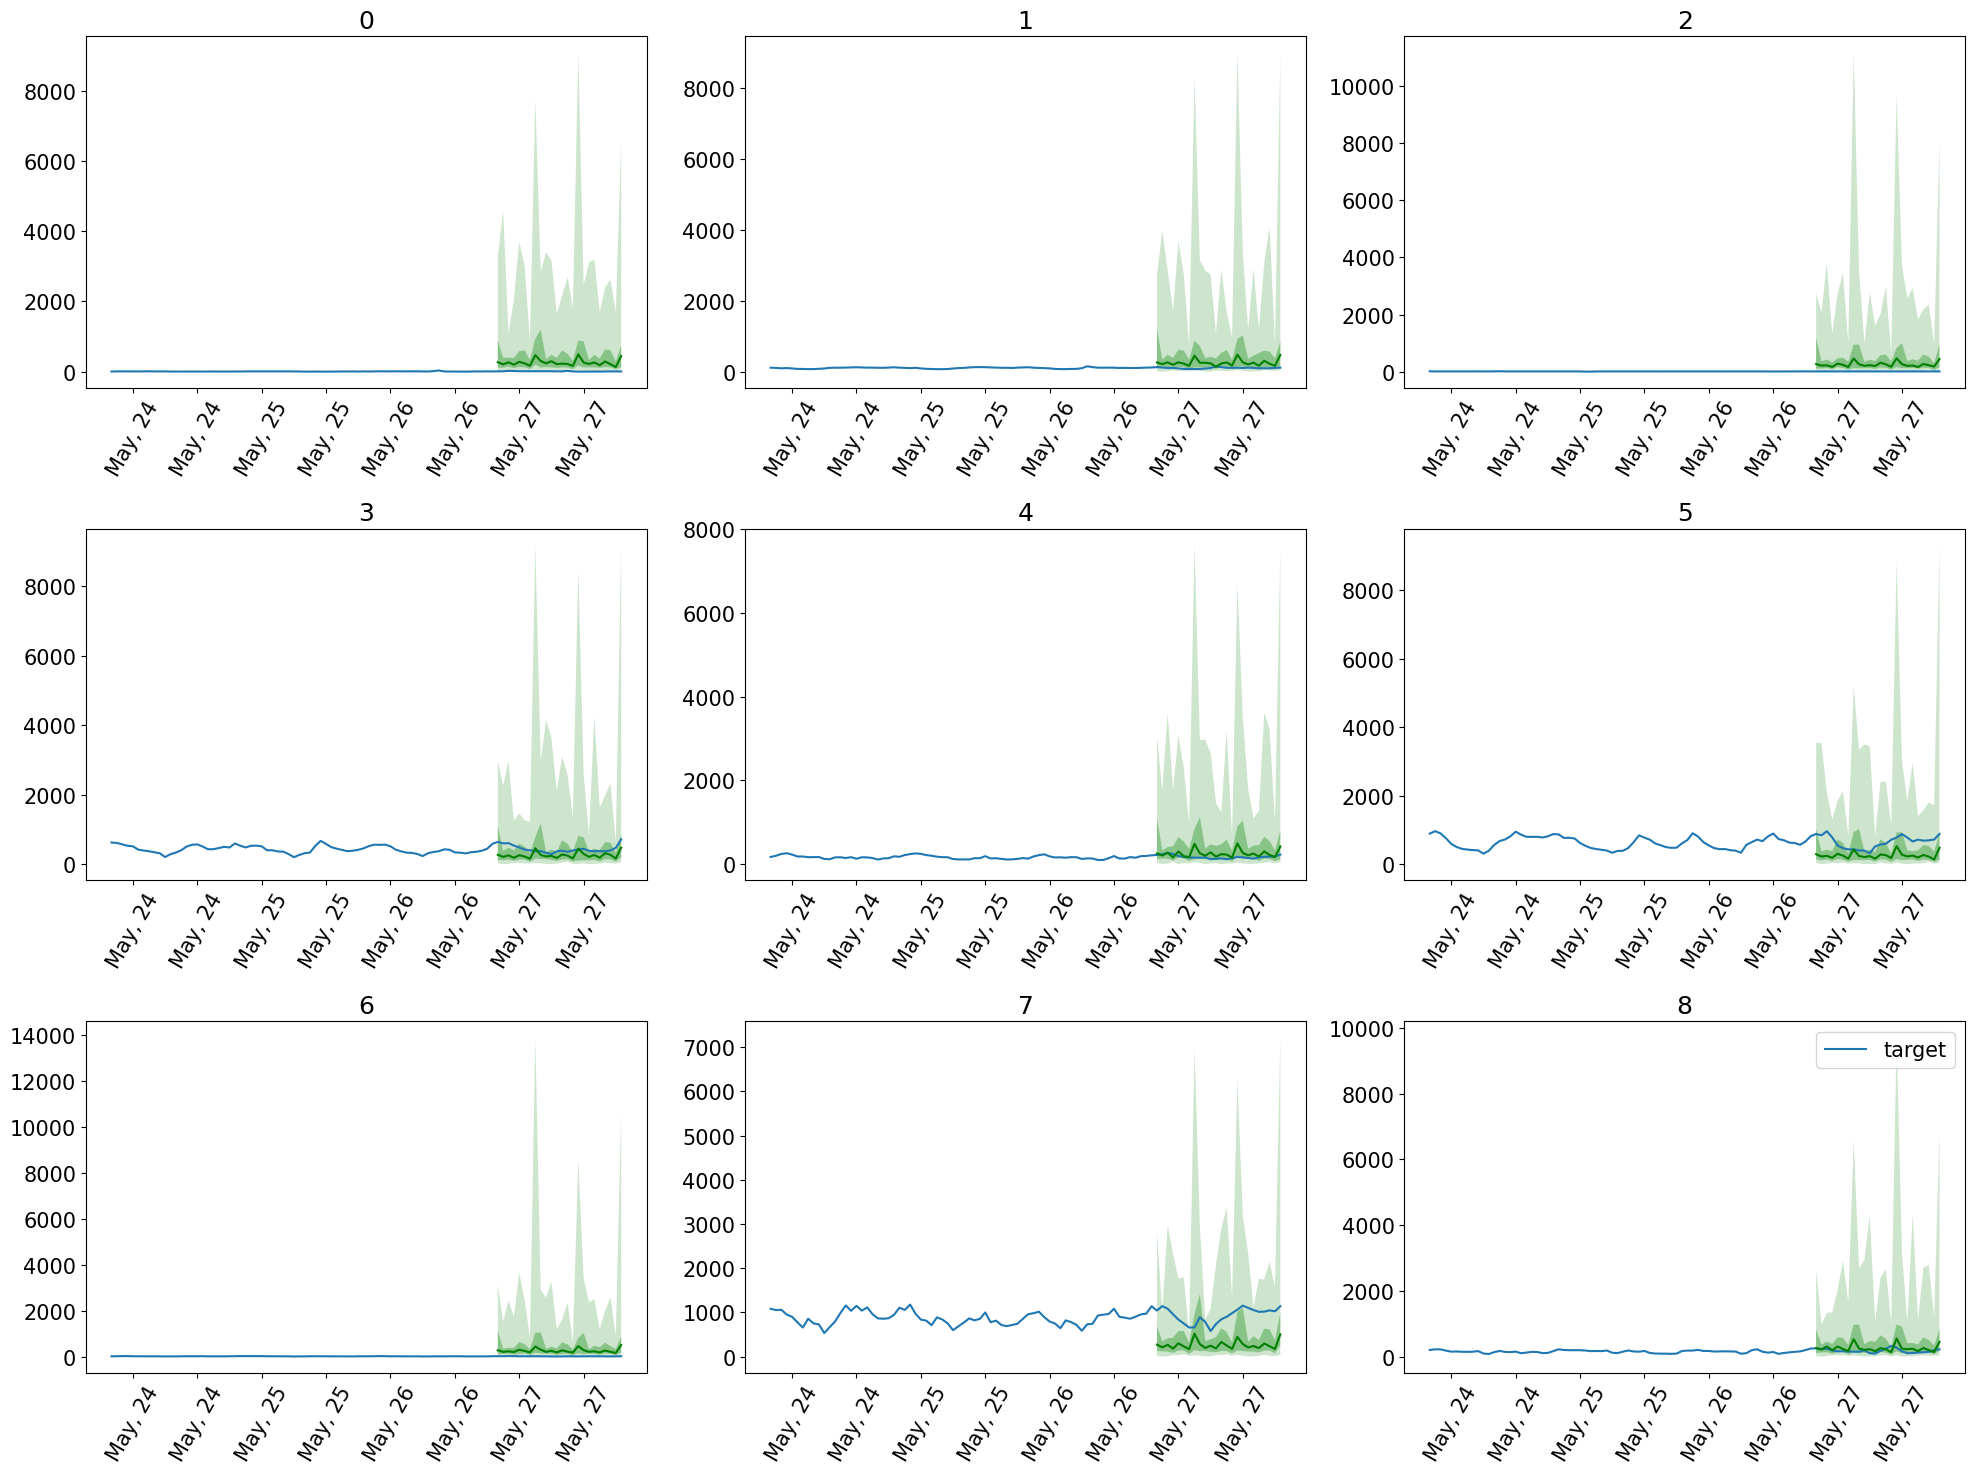

In [15]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
    
    plt.plot(ts, label="target")
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
# plt.figure(figsize=(20, 15))
# date_formater = mdates.DateFormatter('%b, %d')
# plt.rcParams.update({'font.size': 15})

# for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
#     ax = plt.subplot(3, 3, idx+1)

#     plt.plot(ts[-4 * dataset.metadata.prediction_length:], label="target", )
#     forecast.plot( color='g')
#     plt.xticks(rotation=60)
#     ax.xaxis.set_major_formatter(date_formater)

# plt.gcf().tight_layout()
# plt.legend()
# plt.show()

In [ ]:
# def plot_prob_forecasts(ts_entry, forecast_entry):
#     plot_length = 70
#     prediction_intervals = (50.0, 90.0)
#     legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

#     fig, ax = plt.subplots(1, 1, figsize=(10, 7))
#     ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
#     forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
#     plt.grid(which="both")
#     plt.legend(legend, loc="best")
#     plt.show()

In [ ]:
# index = 123
# plot_prob_forecasts(tss[index], forecasts[index])